In [1]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from enum import Enum
import math
from __future__ import division
from sympy import *
init_printing()
from random import randrange, uniform
from datetime import datetime
# %matplotlib notebook
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d 

In [2]:
class TypeOfIntegral(Enum):
    RECTANGULAR = 1,
    TRAPEZOIDAL = 2,
    SIMPSON = 3
    ADAPTATIVE_QUADRATURE = 4
    MONTE_CARLO = 5

In [3]:
class AbstractMathFunction(ABC):
    def __init__(self, BETA:float = 0.1):
        # Define a default function
        self.BETA = BETA
        self.RESOLUTION = 0.00001
        self.n_iterations = 0
#         self.dx = 0.000001
        self.dx = 0.25
       
    @abstractmethod
    def get_result(self, x:float) -> float:
        pass
    
    def get_integral(self, _type:TypeOfIntegral, lim_min:int, lim_max:int, error:float = 0.001, N:int = 1000):
        if(lim_min >= lim_max):
            raise('[AbsMathFunction][ERROR]: Min limit integral bigger than max limit integral')
        
        array_a = np.arange(lim_min, lim_max, self.dx)
        integral = 0
        
        if(_type == TypeOfIntegral.RECTANGULAR):
            print('[AbsMathFunction][LOG]: Solve type is RECTANGULAR')
            for a in array_a:
                b = a + self.dx
                integral += (b-a)*self.get_result((a+b)/2)
                
        elif(_type == TypeOfIntegral.TRAPEZOIDAL):
            print('[AbsMathFunction][LOG]: Solve type is TRAPEZOIDAL')
            for a in array_a:
                b = a + self.dx
                integral += (b-a)*((self.get_result(a)+self.get_result(b))/2)
        
        elif(_type == TypeOfIntegral.SIMPSON):
            print('[AbsMathFunction][LOG]: Solve type is SIMPSON')
            for a in array_a:
                b = a + self.dx
                integral += (b-a)*((self.get_result(a)+4*self.get_result((a+b)/2)+self.get_result(b))/6)
        
        elif(_type == TypeOfIntegral.ADAPTATIVE_QUADRATURE):
            print('[AbsMathFunction][LOG]: Solve type is ADAPTATIVE_QUADRATURE')
            I1 = TypeOfIntegral.TRAPEZOIDAL
            I2 = TypeOfIntegral.RECTANGULAR
            
            result_i1 = self.get_integral(_type=I1, lim_min=lim_min, lim_max=lim_max)
            result_i2 = self.get_integral(_type=I2, lim_min=lim_min, lim_max=lim_max)
            
            error_estimate = abs(result_i1 - result_i2)
            
            if(error_estimate <= error):
                integral = result_i1
            else:
                m = (lim_min+lim_max)/2
                
                print('[AbsMathFunction][LOG]: Solve using "m: %s and error: %s" to divide interval in two integrals' %(m, error_estimate))
                if(lim_min != m) and (lim_max != m):
                    integral_part_one = self.get_integral(_type=_type, lim_min=lim_min, lim_max=m, error=error) 
                    integral_part_two = self.get_integral(_type=_type, lim_min=m, lim_max=lim_max, error=error)
                    integral = integral_part_one + integral_part_two
                else:
                    integral = result_i1
                    print('[AbsMathFunction][ERROR]: The value of error: %s is not converging' %(error))
        elif(_type == TypeOfIntegral.MONTE_CARLO):
            print('[AbsMathFunction][LOG]: Solve type is MONTE CARLO')
            now = datetime.now()
            lim_x_min = lim_min
            lim_x_max = lim_max
            f_average = 0
            f2_average = 0

            for i in range(0, N):
                x_random = uniform(lim_x_min, lim_x_max)
                f_average += f.get_result(x_random)
                f2_average += f.get_result_f2(x_random)

            f_average *= (1/N)
            f2_average *= (1/N)
            integral = (lim_x_max-lim_x_min)*f_average
            self.integral_error = abs(((f2_average-f_average**2)/N)**0.5)
            self.time_process = round((datetime.now() - now).total_seconds(), 2)
            print("Integral: %s" %integral)
            print("Error:    %s" %self.integral_error)
            print("Time Pr.: %s seconds" %self.time_process)
            
        print('[AbsMathFunction][LOG]: Integral result is: %s' %(integral))
        
        return integral
            
    
    def get_diff(self, x:float) -> float:
        return round((self.get_result(x+self.dx) - self.get_result(x))/self.dx, 2)
    
    def get_min_x(self, x0:float) -> float:
        xi = x0
        while(abs(self.get_result(xi)) >= self.RESOLUTION):
            old_value = abs(self.get_result(xi))
            si = self.get_diff(xi)
            xi = xi - self.BETA*si
            new_value = abs(self.get_result(xi))
            
            if(old_value == new_value):
                break
            self.n_iterations += 1

        return round(xi, 2)
    def plot(self, x_min:float, x_max:float):
        data_x = np.arange(x_min, x_max, 0.01)
        data_y = []
        for x in data_x:
            print(self.get_result(0))
            data_y.append(self.get_result(x))
        
        plt.plot(data_x, data_y, label= 'function')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

In [4]:
class SymbolicMathFunction(AbstractMathFunction):
    def __init__(self):
        super().__init__()
        self.z = symbols('z')
        self.symbolic_function = exp(self.z)
        
    def get_result(self, x:float) -> float:   
        return float(self.symbolic_function.subs(self.z,x))
    
    def get_result_f2(self, x:float) -> float:
        return float(self.symbolic_function.subs(self.z,self.symbolic_function).subs(self.z,x))
    
    def get_n_diff(self, x:float, n:int) -> float:
        symbolic_diff = diff(self.symbolic_function, self.z)
        
        if(n>1):
            for i in range(1,n):
                symbolic_diff = diff(symbolic_diff, self.z)
        return symbolic_diff.subs(self.z, x)
    
    def get_integral_error(self, _type:TypeOfIntegral, x:float, lim_min: float, lim_max: float):
        if(lim_min >= lim_max):
            raise('[AbsMathFunction][ERROR]: Min limit integral bigger than max limit integral')
        
        integral_error = 0
        
        if(_type == TypeOfIntegral.RECTANGULAR):
            print('[AbsMathFunction][LOG]: Solve type is RECTANGULAR')
            integral_error = (((lim_max - lim_min)^3)/24)*self.get_n_diff(x=x, n=2)
                
        elif(_type == TypeOfIntegral.TRAPEZOIDAL):
            print('[AbsMathFunction][LOG]: Solve type is TRAPEZOIDAL')
            integral_error = -(((lim_max - lim_min)^3)/12)*self.get_n_diff(x=x, n=2)
        
        elif(_type == TypeOfIntegral.SIMPSON):
            print('[AbsMathFunction][LOG]: Solve type is SIMPSON')
            integral_error = -(((lim_max - lim_min)^5)/2880)*self.get_n_diff(x=x, n=4)
        
        print('[AbsMathFunction][LOG]: Integral error result is: %s' %(integral_error))
        
        self.integral_error = integral_error
        
        return integral_error
    
    def plot(self, x_min:float, x_max:float):
        p1 = plot(self.symbolic_function, (self.z, x_min, x_max), show=True, line_color='b')


In [5]:
class FunctionTestLetterA(SymbolicMathFunction):
    def __init__(self):
        super().__init__()
        self.symbolic_function = (4)/(1+self.z**2)

In [6]:
class FunctionTestLetterB(SymbolicMathFunction):
    def __init__(self):
        super().__init__()
        self.symbolic_function = (self.z + self.z**(1/2))**(1/2)

In [7]:
class FunctionTestLetterC(SymbolicMathFunction):
    def __init__(self):
        super().__init__()
        self.symbolic_function = (self.z)**(1/2)

# Exercício 1 - A

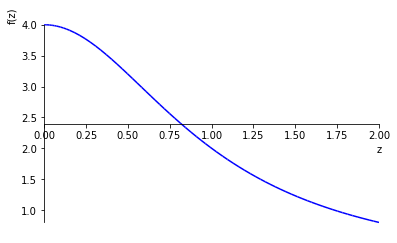

In [110]:
# Plot function
f = FunctionTestLetterA()
f.plot(0,2)

In [121]:
# Get array of N to calculate integral
a = (np.arange(9)+1)*10
b = (np.arange(9)+1)*100
c = (np.arange(9)+1)*1000
d = (np.arange(9)+1)*10000
array_n = np.concatenate((a,b,c,d),axis=0)

In [122]:
# Calculate integral array to plot graph
real_result = 3.141592654
for n in array_n:
    print("N: %s" %n)
    integer = f.get_integral(_type=TypeOfIntegral.MONTE_CARLO, lim_min=0, lim_max=1, N = int(n))
    if(n == 10):
        array_integral = np.array([integer])
        array_error = np.array([f.integral_error])
        array_time = np.array([f.time_process])
        array_real_result = np.array([real_result])
    else:
        array_integral = np.concatenate((array_integral, np.array([integer])),axis=0)
        array_error = np.concatenate((array_error, np.array([f.integral_error])),axis=0)
        array_time = np.concatenate((array_time, np.array([f.time_process])),axis=0)
        array_real_result = np.concatenate((array_real_result, np.array([real_result])),axis=0)

N: 10
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 3.121136639653594
Error:    0.9651823263217156
Time Pr.: 0.01 seconds
[AbsMathFunction][LOG]: Integral result is: 3.121136639653594
N: 20
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 2.9793513589215395
Error:    0.6496728923924054
Time Pr.: 0.03 seconds
[AbsMathFunction][LOG]: Integral result is: 2.9793513589215395
N: 30
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 3.326116973997091
Error:    0.5972440215849328
Time Pr.: 0.03 seconds
[AbsMathFunction][LOG]: Integral result is: 3.326116973997091
N: 40
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 3.0914103374744046
Error:    0.47785771874631666
Time Pr.: 0.05 seconds
[AbsMathFunction][LOG]: Integral result is: 3.0914103374744046
N: 50
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 3.197137041727872
Error:    0.44333935151347714
Time Pr.: 0.06 seconds
[AbsMathFunction][LOG]: Integral result is: 3.197137041727872
N: 6

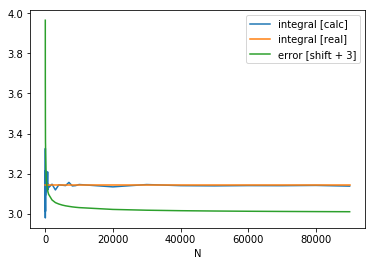

In [136]:
# Plot graph integral and error vs N
plt.plot(array_n, array_integral, label= 'integral [calc]')
plt.plot(array_n, array_real_result, label= 'integral [real]')
plt.plot(array_n, array_error + 3, label= 'error [shift + 3]')
plt.xlabel('N')
plt.legend()
plt.show()

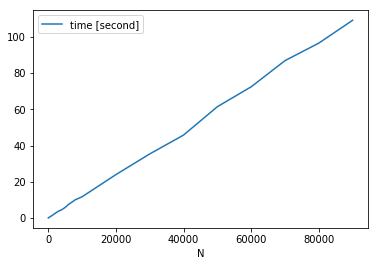

In [137]:
# Plot graph time vs N
plt.plot(array_n, array_time, label= 'time [second]')
plt.xlabel('N')
plt.legend()
plt.show()

# Exercício 1 - B

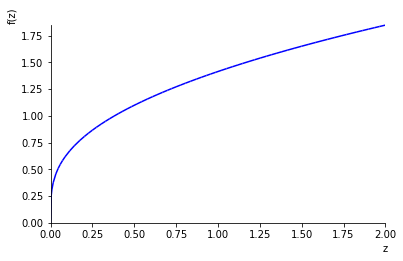

In [139]:
# Plot function
f = FunctionTestLetterB()
f.plot(0,2)

In [144]:
# Get array of N to calculate integral
a = (np.arange(9)+1)*10
b = (np.arange(9)+1)*100
c = (np.arange(9)+1)*1000
d = (np.arange(9)+1)*10000
array_n = np.concatenate((a,b,c,d),axis=0)

In [145]:
# Calculate integral array to plot graph
real_result = 1.0453
for n in array_n:
    print("N: %s" %n)
    integer = f.get_integral(_type=TypeOfIntegral.MONTE_CARLO, lim_min=0, lim_max=1, N = int(n))
    if(n == 10):
        array_integral = np.array([integer])
        array_error = np.array([f.integral_error])
        array_time = np.array([f.time_process])
        array_real_result = np.array([real_result])
    else:
        array_integral = np.concatenate((array_integral, np.array([integer])),axis=0)
        array_error = np.concatenate((array_error, np.array([f.integral_error])),axis=0)
        array_time = np.concatenate((array_time, np.array([f.time_process])),axis=0)
        array_real_result = np.concatenate((array_real_result, np.array([real_result])),axis=0)

N: 10
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 1.0819562463940244
Error:    0.1670056996740824
Time Pr.: 0.01 seconds
[AbsMathFunction][LOG]: Integral result is: 1.0819562463940244
N: 20
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 1.0135248427764054
Error:    0.13903109420420023
Time Pr.: 0.02 seconds
[AbsMathFunction][LOG]: Integral result is: 1.0135248427764054
N: 30
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 1.0719385350081787
Error:    0.09873222098030314
Time Pr.: 0.03 seconds
[AbsMathFunction][LOG]: Integral result is: 1.0719385350081787
N: 40
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 1.0867841679538663
Error:    0.08152636337499128
Time Pr.: 0.03 seconds
[AbsMathFunction][LOG]: Integral result is: 1.0867841679538663
N: 50
[AbsMathFunction][LOG]: Solve type is MONTE CARLO
Integral: 0.9981723030929043
Error:    0.08959733438338596
Time Pr.: 0.04 seconds
[AbsMathFunction][LOG]: Integral result is: 0.9981723030929

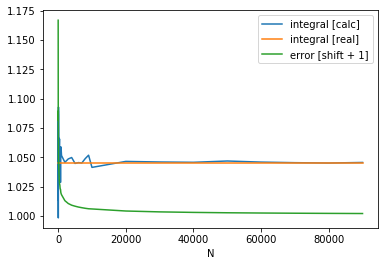

In [149]:
# Plot graph integral and error vs N
plt.plot(array_n, array_integral, label= 'integral [calc]')
plt.plot(array_n, array_real_result, label= 'integral [real]')
plt.plot(array_n, array_error + 1, label= 'error [shift + 1]')
plt.xlabel('N')
plt.legend()
plt.show()

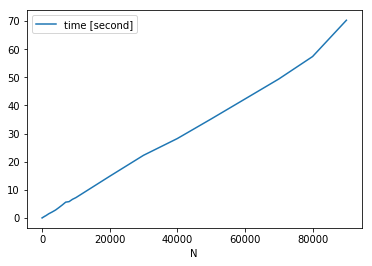

In [150]:
# Plot graph time vs N
plt.plot(array_n, array_time, label= 'time [second]')
plt.xlabel('N')
plt.legend()
plt.show()

# Exercício 2

In [8]:
def volume_object(N:int):
    now = datetime.now()
    xdata = np.array([])
    ydata = np.array([])
    zdata = np.array([])
    lim_x_min = 1
    lim_x_max = 4
    lim_y_min = -3
    lim_y_max = 4
    lim_z_min = -2
    lim_z_max = 2

    n_total = N
    n_fig = 0
    for i in range(0, n_total):
        x_random = uniform(lim_x_min, lim_x_max)
        y_random = uniform(lim_y_min, lim_y_max)
        z_random = uniform(lim_z_min, lim_z_max)

        toroid = z_random**2 + ((x_random**2+y_random**2)**0.5-3)**2
        if(x_random > 1) and (y_random >= -3) and (toroid <= 1):
            n_fig += 1
            xdata = np.concatenate((xdata, np.array([x_random])), axis=0)
            ydata = np.concatenate((ydata, np.array([y_random])), axis=0)
            zdata = np.concatenate((zdata, np.array([z_random])), axis=0)
    v_total = (lim_x_max-lim_x_min)*(lim_y_max-lim_y_min)*(lim_z_max-lim_z_min)
    v_figura = v_total*(n_fig/n_total)
    time_process = round((datetime.now() - now).total_seconds(), 2)
    
    return [v_figura, time_process, xdata, ydata, zdata]

In [9]:
[v_figura, time_process, xdata, ydata, zdata] = volume_object(N=100000)
print("The total volume is: %s" %v_figura)

The total volume is: 22.2348


In [10]:
ax = plt.axes(projection='3d')
ax.scatter(xdata, ydata, zdata, c=zdata, cmap='viridis', linewidth=0.001)

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [16]:
# Get array of N to calculate integral
a = (np.arange(9)+1)*100
b = (np.arange(9)+1)*1000
c = (np.arange(9)+1)*10000
d = (np.arange(9)+1)*100000
array_n = np.concatenate((a,b,c,d),axis=0)
# array_n = np.concatenate((a,b),axis=0)

In [17]:
# Calculate integral array to plot graph
array_volume = np.array([])
array_time = np.array([])
for n in array_n:
    print("N: %s" %n)
    [v_figura, time_process, xdata, ydata, zdata] = volume_object(N=int(n))
    print(v_figura)
    if(n == 100):
        array_volume = np.array([v_figura])
        array_time = np.array([time_process])
    else:
        array_volume = np.concatenate((array_volume, np.array([v_figura])),axis=0)
        array_time = np.concatenate((array_time, np.array([time_process])),axis=0)

N: 100
25.2
N: 200
18.900000000000002
N: 300
20.16
N: 400
22.26
N: 500
22.848000000000003
N: 600
21.84
N: 700
21.12
N: 800
22.365
N: 900
21.84
N: 1000
21.84
N: 2000
21.924
N: 3000
22.287999999999997
N: 4000
21.987
N: 5000
22.26
N: 6000
21.84
N: 7000
22.152
N: 8000
22.1025
N: 9000
23.184
N: 10000
21.949199999999998
N: 20000
21.882
N: 30000
22.134
N: 40000
22.0689
N: 50000
22.033199999999997
N: 60000
22.121399999999998
N: 70000
21.988799999999998
N: 80000
21.94395
N: 90000
21.9268
N: 100000
22.074360000000002
N: 200000
22.105019999999996
N: 300000
22.064
N: 400000
22.099980000000002
N: 500000
22.173479999999998
N: 600000
22.12448
N: 700000
22.130640000000003
N: 800000
22.180935
N: 900000
22.06624


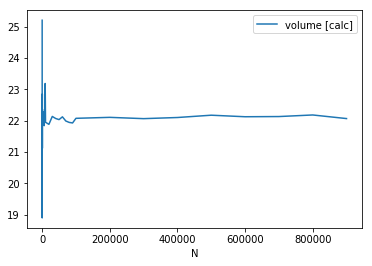

In [18]:
# Plot graph integral and error vs N
plt.plot(array_n, array_volume, label= 'volume [calc]')
plt.xlabel('N')
plt.legend()
plt.show()

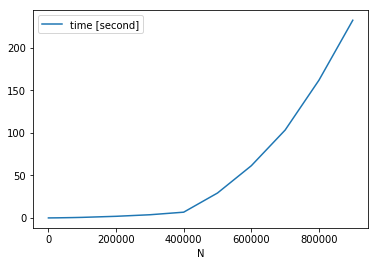

In [19]:
# Plot graph integral and error vs N
plt.plot(array_n, array_time, label= 'time [second]')
plt.xlabel('N')
plt.legend()
plt.show()

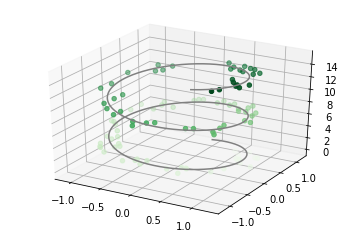

In [156]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [158]:
np.random.random(10)

array([0.58999342, 0.27683195, 0.89005359, 0.58651666, 0.9652634 ,
       0.34858152, 0.90442719, 0.48502483, 0.82167564, 0.65402127])